In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import keras
from keras import layers
import tensorflow as tf

In [42]:
data_file_path = "../datasets/red_wine/datasets/"

In [43]:
# setup plotting
# display(plt.style.available)
plt.style.use("seaborn-v0_8-whitegrid")
# setup defaults
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large",
       titleweight = "bold", titlesize = 18, titlepad = 10)

In [44]:
red_wine = pd.read_csv(data_file_path + "red_wine.csv")
display(red_wine.shape)
display(red_wine.head())

(1599, 12)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [45]:
# pick out random data to train
df_train = red_wine.sample(frac=0.7, random_state=0)

# remove the training data from valid data
df_valid = red_wine.drop(df_train.index)
display(df_train.head())

# scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)
display(df_train.head())

# remove target value from training data
X_train = df_train.drop("quality", axis=1)
X_valid = df_valid.drop("quality", axis=1)
y_train = df_train["quality"]
y_valid = df_valid["quality"]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6
979,12.2,0.450,0.49,1.40,0.075,3.0,6.0,0.99690,3.13,0.63,10.4,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,0.548673,0.239726,0.544304,0.092308,0.237435,0.366197,0.212014,0.619193,0.291262,0.260606,0.369231,0.6
1032,0.309735,0.479452,0.000000,0.246154,0.105719,0.056338,0.028269,0.645088,0.475728,0.121212,0.184615,0.4
1002,0.398230,0.116438,0.417722,0.088462,0.050260,0.169014,0.074205,0.387662,0.378641,0.309091,0.507692,0.8
487,0.495575,0.359589,0.455696,0.069231,0.032929,0.056338,0.028269,0.619193,0.291262,0.054545,0.246154,0.6
979,0.672566,0.226027,0.620253,0.038462,0.071057,0.028169,0.000000,0.520183,0.252427,0.181818,0.307692,0.4


In [46]:
# keras model
red_wine_model_keras_sequential = keras.Sequential(
    [
        keras.Input((X_train.shape[1],)),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(1),
    ]
)

In [47]:
# using "adam" - a "self-tuning" SGD algorithm
red_wine_model_keras_sequential.compile(
    optimizer="adam",
    loss="mae",
)

In [48]:
# train
history_keras_sequential = red_wine_model_keras_sequential.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=10,
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.3784 - val_loss: 0.1421
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1449 - val_loss: 0.1264
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1285 - val_loss: 0.1160
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1180 - val_loss: 0.1152
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1129 - val_loss: 0.1043
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1079 - val_loss: 0.1075
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1050 - val_loss: 0.1028
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1038 - val_loss: 0.1024
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1016 - val_loss: 0.0996
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1031 - val_loss: 0.0999


<Axes: >

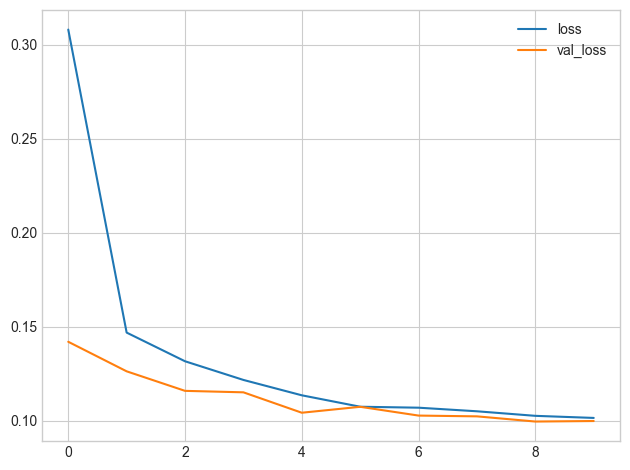

In [49]:
history_keras_sequential_df = pd.DataFrame(history_keras_sequential.history)
history_keras_sequential_df.plot()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


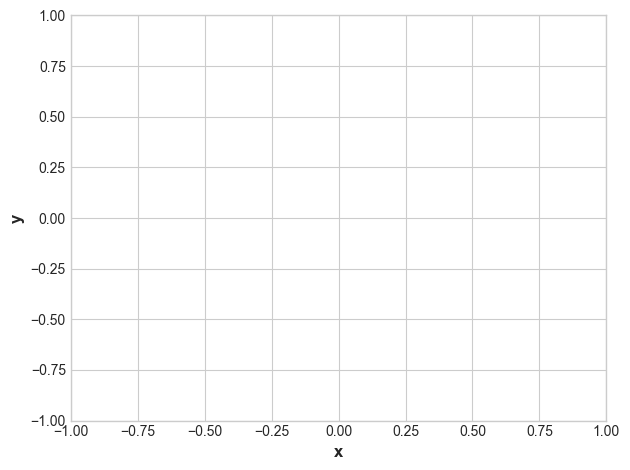

In [ ]:
x = X_valid
y = red_wine_model_keras_sequential.predict(X_valid)

plt.figure(dpi=100)
plt.plot(x, y, "k")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("x")
plt.ylabel("y")
w, b = red_wine_model_keras_sequential.get_weights()[:2]
plt.show()